In [3]:
import pandas_datareader as web
import datetime
from Indicator import Indicator

from keras.models import load_model,Sequential
from keras.layers import Input, Dense, LSTM,Dropout
from keras.utils import to_categorical
from keras.callbacks import Callback, ModelCheckpoint


import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.metrics import confusion_matrix , accuracy_score

def signal_to_catagorical(data):
  data.loc[data['Signal'] == 'wait ot hold', 'Signal'] = 'wait or hold'
  data.loc[data['Signal'] == 'buy', 'Signal'] = 0
  data.loc[data['Signal'] == 'sell', 'Signal'] = 1 
  data.loc[data['Signal'] == 'wait or hold', 'Signal'] = 2 
  return data

def fillindicator(df):
    indicator = Indicator()
    train_set = indicator.MACD(df,12,26,9,1)#MACD 1
    train_set = indicator.MACD(df,40,60,34,2)#MACD 2
    train_set = indicator.DMI(df,14)
    train_set = indicator.STOCHRSI(df)
    train_set = indicator.AO(df)
    train_set = indicator.WILLIANSR(df)
    train_set = indicator.RSI(df)
    train_set = indicator.MA(df,26)
    train_set['MA-26'] = train_set['MA']
    train_set = indicator.MA(df,15)
    train_set = indicator.check_trend(df)
    return train_set

def shiftdata(df,col_name,sft):
    for i in range(sft):
        i+=1
        shiftname = col_name+'-'+str(i)
        df[shiftname] = df[col_name].shift(i)

    return df

def norm(df,col_name):# this will get columnname + _n
    #Normalize data each colunm in to range -1 to 1
    df[col_name+'_n'] = 2*(df[col_name]-df[col_name].min())/(df[col_name].max()-df[col_name].min())-1    
    return df

def add_shift_day(data,day):
  r_list = []
  for i in range(day,len(data)):#Number mean day to shift
    r_list.append(data[i-day : i])
  return np.array(r_list)


start = datetime.datetime(2015,10,1)#26 day before start year for make indicator
end = datetime.datetime(2020,1,1)

In [7]:
modellist = [f for f in glob.glob("myModel/*.h5")]
modellist

['myModel\\Model4_1_100ep.h5',
 'myModel\\Model4_2_150ep.h5',
 'myModel\\Model4_3_200ep.h5',
 'myModel\\Model4_4_250.h5',
 'myModel\\Model4_5_300.h5',
 'myModel\\Model4_6_350.h5']

In [4]:
stock = 'true.bk'
df = web.DataReader(stock,'yahoo',start,end)
df = fillindicator(df)
df['AO-signal'] = np.where(df['AO'] > df['AO'].shift(1),1,0)
df.loc[df['Trend'] == 'Down', 'Trend'] = 0.1
df.loc[df['Trend'] == 'Up', 'Trend'] = 0.9 

#Delta
df['MACD-SL-1'] = df['MACD-1'] - df['SIGNAL LINE1']
df['MACD-SL-2'] = df['MACD-2'] - df['SIGNAL LINE2']
df['DMI'] = df['plusDI'] - df['minusDI']
df['STOCHRSI'] = df['%K'] - df['%D']
df['MA-trend'] = df['MA-26'] - df['Close']

#MACD
df = norm(df,'MACD-SL-1')
df = norm(df,'MACD-SL-2')
df = norm(df,'MACD-1')
df = norm(df,'MACD-2')
df = norm(df,'SIGNAL LINE1')
df = norm(df,'SIGNAL LINE2')

#DMI
df = norm(df,'plusDI')
df = norm(df,'minusDI')
df = norm(df,'DMI')

#StochasticRSI
df = norm(df,'%K')
df = norm(df,'%D')
df = norm(df,'STOCHRSI')

#Other
df = norm(df,'Close')
df = norm(df,'%R')
df = norm(df,'RSI')
df = norm(df,'AO')
df = norm(df,'MA-trend')
df = df[63:]

C:\Users\jame_\anaconda3\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\jame_\anaconda3\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


C:\Users\jame_\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\jame_\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\jame_\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

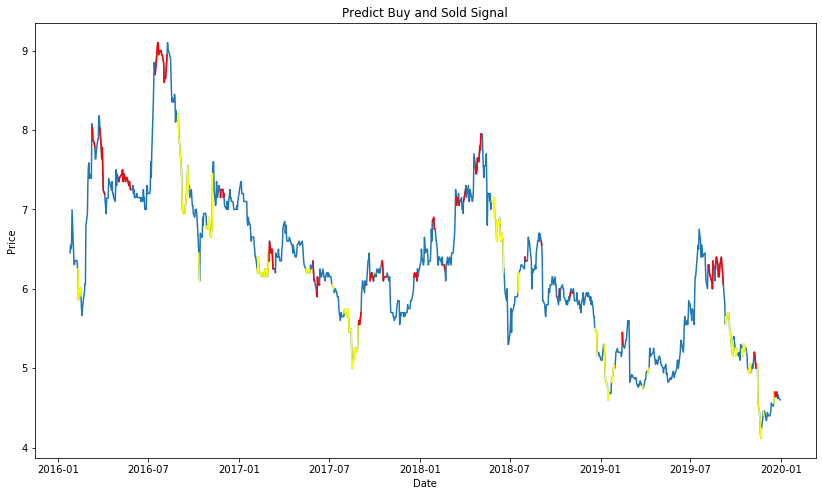

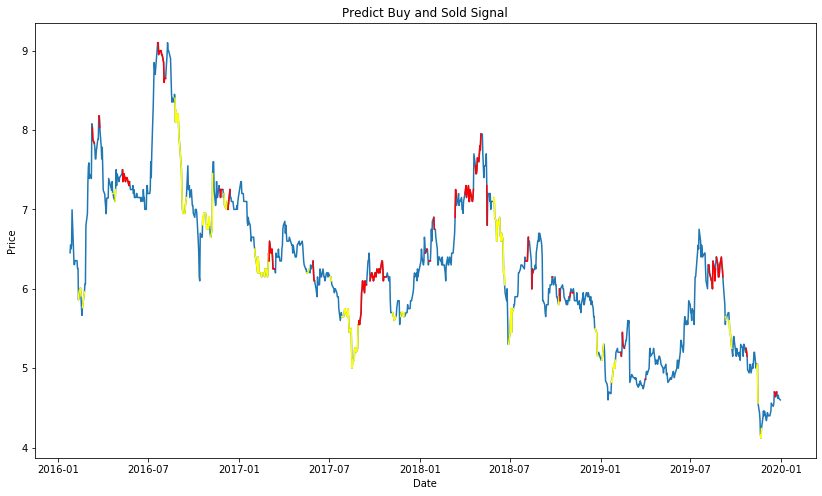

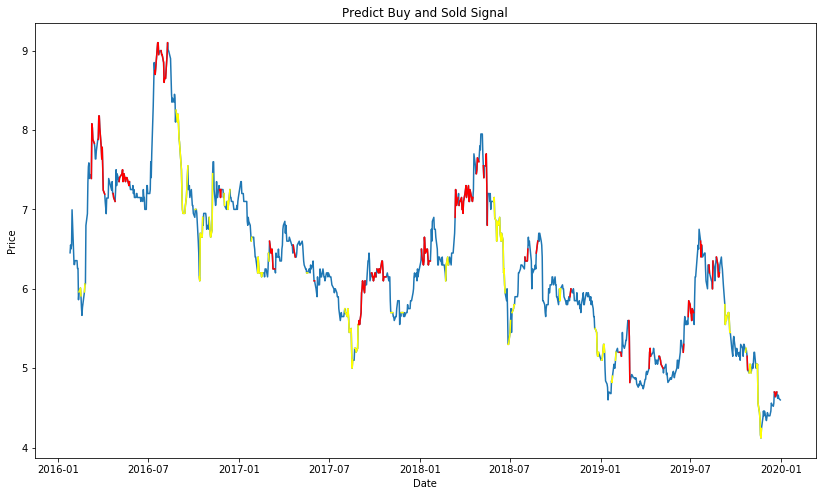

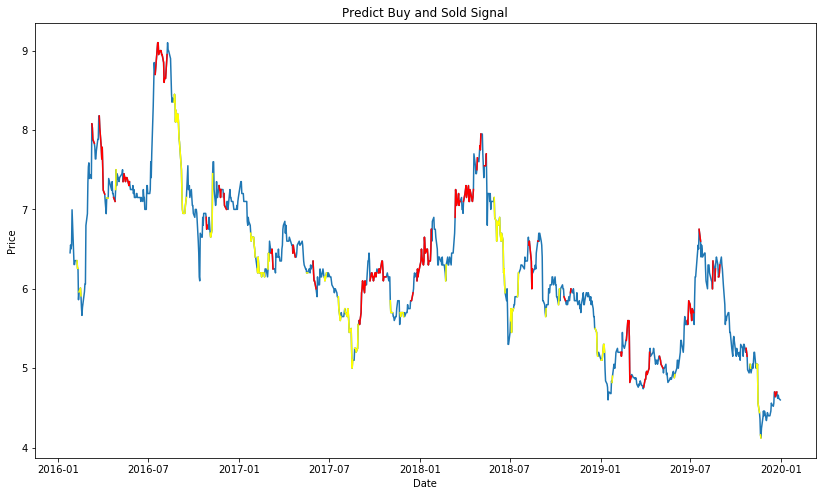

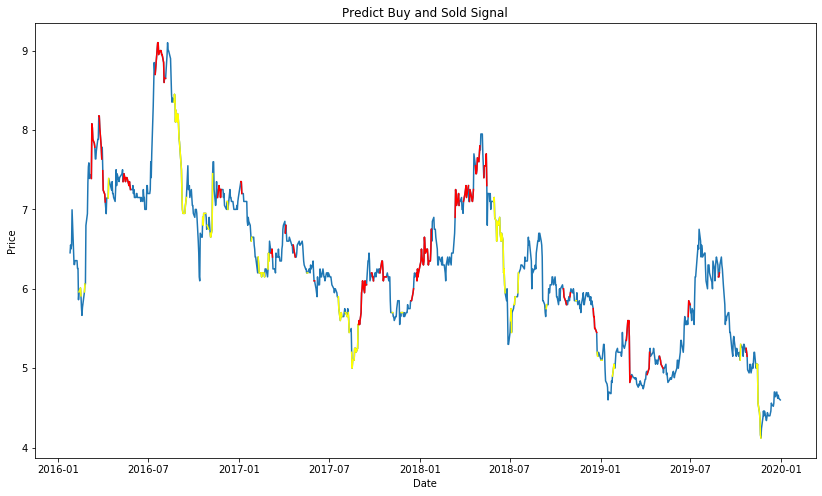

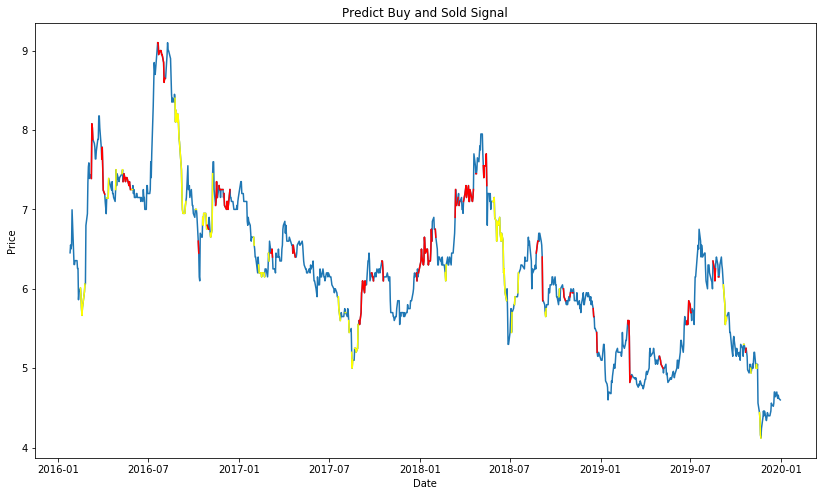

In [8]:
for md in modellist:
    model = load_model(md)
    p_test = df
    x_test = p_test[['MACD-SL-1_n','DMI_n','MACD-SL-2_n','AO_n','RSI_n','MA-trend']].values
    x_test = add_shift_day(x_test,14)
    y_pred = model.predict(x_test)
    y_pred = np.argmax(y_pred,axis = -1)
    p_test = p_test.iloc[14:]

    p_test['pred'] = y_pred
    p_test['pred_b'] = np.where(p_test['pred'] == 0,p_test['Close'],np.nan)
    p_test['pred_s'] = np.where(p_test['pred'] == 1,p_test['Close'],np.nan)

    plt.figure(figsize=(14,8))
    # plt.grid()
    plt.title('Predict Buy and Sold Signal')
    plt.plot(p_test['Close'])
    plt.plot(p_test['pred_b'],color='yellow')
    plt.plot(p_test['pred_s'],color='red')
    plt.ylabel('Price')
    plt.xlabel('Date')